# Testing of REMD

## Setup

In [4]:
using Pkg
Pkg.activate("../../")

  Activating project at `d:\Projects\OpenSource\ReplicaExchangeMD.jl`


In [5]:
using ReplicaExchangeMD
# using Molly

In [6]:
Threads.nthreads()

8

In [7]:
using Plots

In [8]:
using BenchmarkTools

## System Parameters

In [9]:
n_atoms = 100
atom_mass = 10.0u"u"
atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1") for i in 1:n_atoms];

In [10]:
boundary = CubicBoundary(2.0u"nm", 2.0u"nm", 2.0u"nm")
coordinates = place_atoms(n_atoms, boundary; min_dist=0.3u"nm"); # Random placement without clashing

In [11]:
temp = 100.0u"K"
velocities = [velocity(atom_mass, temp) for i in 1:n_atoms];

In [12]:
pairwise_inters = (LennardJones(),) # Don't forget the trailing comma!

(LennardJones{false, NoCutoff, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}(NoCutoff(), false, true, 1, 1, kJ nm^-1 mol^-1, kJ mol^-1),)

In [13]:
nb_matrix = trues(n_atoms, n_atoms)
for i in 1:(n_atoms ÷ 2)
    nb_matrix[i, i + (n_atoms ÷ 2)] = false
    nb_matrix[i + (n_atoms ÷ 2), i] = false
end

neighbor_finder = DistanceNeighborFinder(
    nb_matrix=nb_matrix,
    n_steps=10,
    dist_cutoff=1.5u"nm",
)

DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}
  Size of nb_matrix = (100, 100)
  n_steps = 10
  dist_cutoff = 1.5 nm

## Test Simulation for normal system

In [26]:
sys = System(
    atoms=atoms,
    pairwise_inters=pairwise_inters,
    coords=coordinates,
    velocities=velocities,
    boundary=boundary,
    loggers=(
        temp=TemperatureLogger(10),
        coords=CoordinateLogger(10),
    ),
    neighbor_finder=neighbor_finder,
)

System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [27]:
simulator = Langevin(
    dt=0.005u"ps",
    temperature=temp,
    friction=0.1u"ps^-1",
);

In [28]:
@time Molly.simulate!(sys, simulator, 10_000)

  2.578777 seconds (1.34 M allocations: 1.830 GiB, 9.05% gc time)


System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [29]:
length(values(sys.loggers.temp))

1001

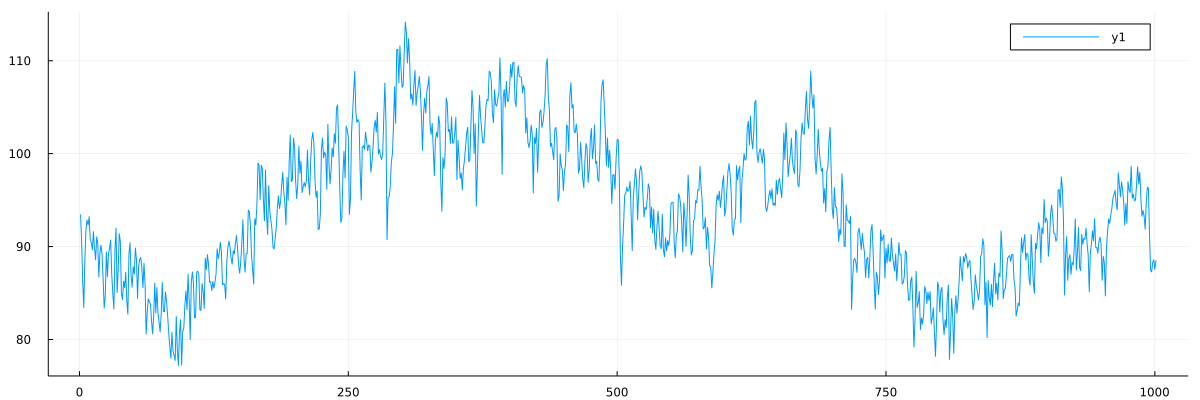

In [28]:
plot(ustrip.(values(sys.loggers.temp)), size=(1200, 400))

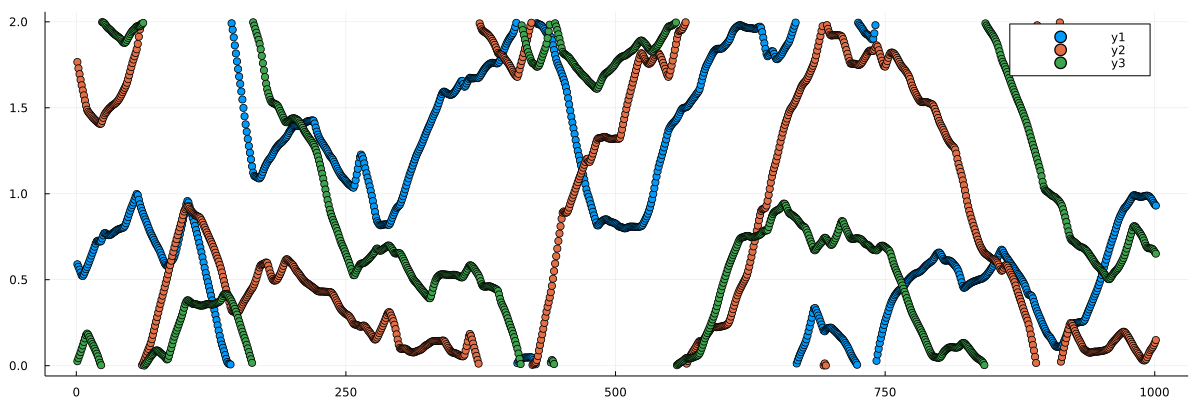

In [29]:
scatter([ustrip(c[50][1]) for c in values(sys.loggers.coords)], size=(1200, 400))
scatter!([ustrip(c[50][2]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][3]) for c in values(sys.loggers.coords)])

# Test simulation for T-REMD

In [11]:
n_replicas = 4
repsys = ReplicaSystem(
    atoms=atoms,
    replica_coords=[coordinates for _ in 1:n_replicas],
    replica_velocities=nothing,
    n_replicas=n_replicas,
    boundary=boundary,
    pairwise_inters=pairwise_inters,
    replica_loggers=Tuple((temp=TemperatureLogger(10), coords=CoordinateLogger(10)) for i in 1:n_replicas),
    neighbor_finder=neighbor_finder,
)

ReplicaSystem containing 4 replicas with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [62]:
temp_vals = [120.0u"K", 180.0u"K", 240.0u"K", 300.0u"K"]
remd_simulator = TemperatureREMD(
    dt=0.005u"ps",
    temperatures=temp_vals,
    simulators=[
        Langevin(
            dt=0.005u"ps",
            temperature=tmp,
            friction=0.1u"ps^-1",
        )
        for tmp in temp_vals],
    exchange_time=2.5u"ps",
);

remd_simulator = HamiltonianREMD(
    dt=0.005u"ps",
    temperature=temp,
    simulators=[
        Langevin(
            dt=0.005u"ps",
            temperature=temp,
            friction=0.1u"ps^-1",
        )
        for _ in 1:n_replicas],
    exchange_time=2.5u"ps",
);

In [63]:
@time simulate!(repsys, remd_simulator, 10_000; assign_velocities=true);
# @time simulate!(repsys, remd_simulator, 10_000);

  3.903948 seconds (2.02 M allocations: 3.616 GiB, 26.07% gc time)


In [64]:
repsys.exchange_logger.n_exchanges / repsys.exchange_logger.n_attempts

0.36666666666666664

In [65]:
[(s, ind) for (s, ind) in zip(repsys.exchange_logger.steps, repsys.exchange_logger.indices)]

11-element Vector{Tuple{Int64, Tuple{Int64, Int64}}}:
 (500, (2, 3))
 (1000, (3, 4))
 (1500, (2, 3))
 (2000, (3, 4))
 (4000, (1, 2))
 (4000, (3, 4))
 (4500, (2, 3))
 (5500, (2, 3))
 (7000, (1, 2))
 (9000, (3, 4))
 (10000, (3, 4))

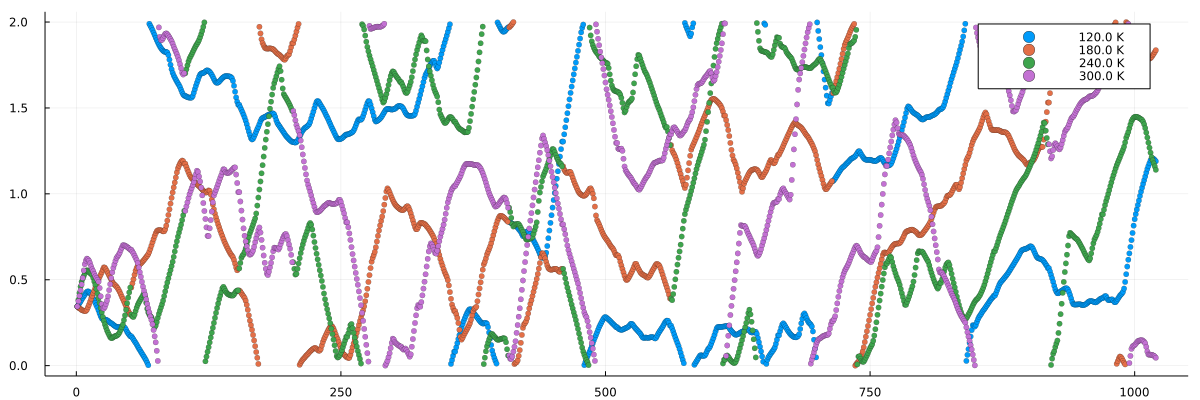

In [66]:
s = scatter([ustrip(c[10][1]) for c in values(repsys.replicas[1].loggers.coords)], label=temp_vals[1], markersize=3.0, markerstrokewidth=0.2, size=(1200, 400))
for repidx=2:n_replicas
    scatter!([ustrip(c[10][1]) for c in values(repsys.replicas[repidx].loggers.coords)], label=temp_vals[repidx], markersize=3.0, markerstrokewidth=0.2)
end
# savefig(s, "plots/x_coordiantes_of_atom_10_in_each_replica_v2.png")
s

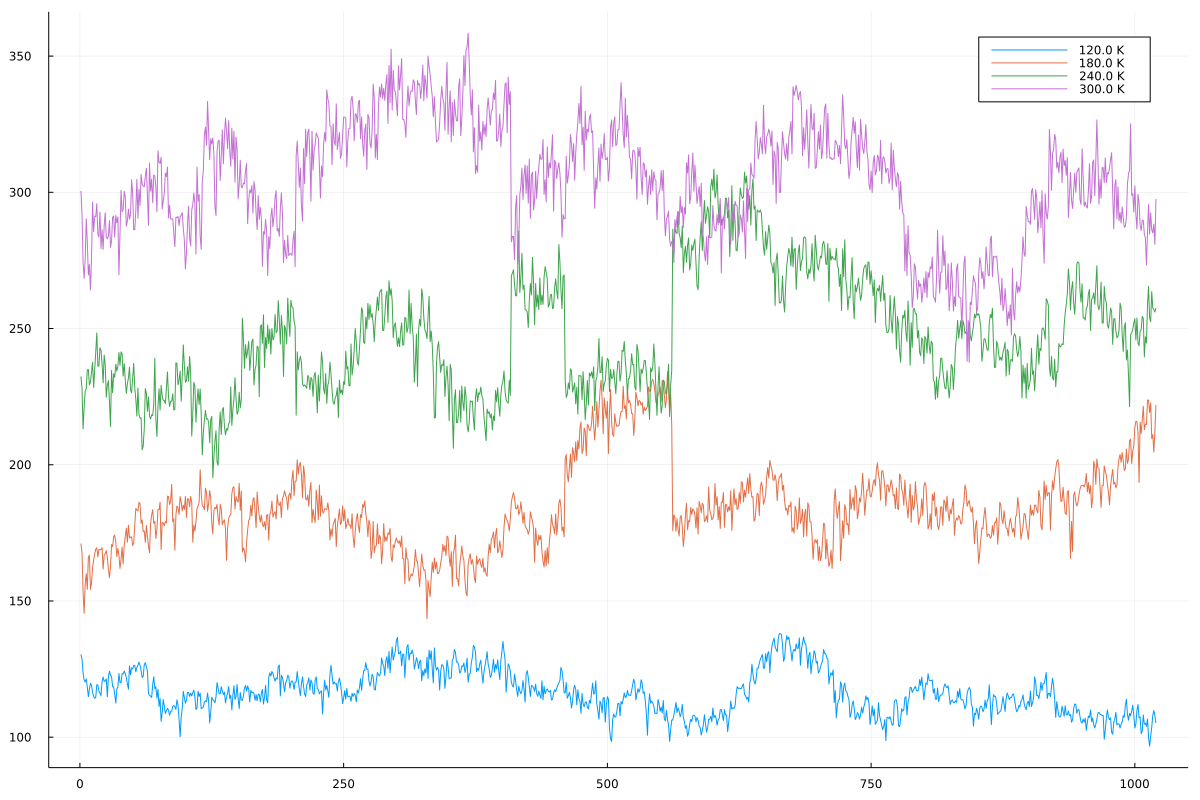

In [67]:
s = plot(ustrip.(values(repsys.replicas[1].loggers.temp)), label=temp_vals[1], linestyle=:solid, size=(1200, 800))
for repidx=2:n_replicas
    plot!(ustrip.(values(repsys.replicas[repidx].loggers.temp)), label=temp_vals[repidx], linestyle=:solid)
end
# savefig(s, "plots/temperature_of_each_replica_v2.png")
s

In [68]:
using Statistics

for repidx=1:n_replicas
    mean(ustrip.(values(repsys.replicas[repidx].loggers.temp))) |> println
end

116.64860871394062
184.68269704602196
247.26282238751972
303.7718532171534


# Test simulation for H-REMD

In [14]:
n_replicas = 4
λ_vals = [(i-1)*(1/n_replicas) for i in 1:n_replicas]
replica_pairwise_inters = [(LennardJonesSoftCore(α=1, λ=λ_vals[i], p=2, nl_only=true),
                            CoulombSoftCore(α=1, λ=λ_vals[i], p=2, nl_only=true)) for i in 1:n_replicas]

replica_loggers = [(temp=TemperatureLogger(10),
                    potential_energy=PotentialEnergyLogger(10),
                    energy=TotalEnergyLogger(10)) for i in 1:n_replicas]

4-element Vector{NamedTuple{(:temp, :potential_energy, :energy), Tuple{GeneralObservableLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, typeof(Molly.temperature_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.potential_energy_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.total_energy_wrapper)}}}}:
 (temp = TemperatureLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}} with n_steps 10, 0 temperatures recorded, potential_energy = PotentialEnergyLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}} with n_steps 10, 0 energies recorded, energy = TotalEnergyLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}} with n_steps 10, 0 energies recorded)
 (temp = TemperatureLogger{Qu

In [15]:
repsys2 = ReplicaSystem(
    atoms=atoms,
    replica_coords=[copy(coordinates) for _ in 1:n_replicas],
    replica_velocities=[copy(velocities) for _ in 1:n_replicas],
    n_replicas=n_replicas,
    boundary=boundary,
    replica_pairwise_inters=replica_pairwise_inters,
    replica_loggers=replica_loggers,
    neighbor_finder=neighbor_finder,
)

ReplicaSystem containing 4 replicas with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [16]:
temp2 = 298.0u"K"
simulator2 = HamiltonianREMD(
    dt=0.005u"ps",
    temperature=temp2,
    simulators=[
        Langevin(
            dt=0.005u"ps",
            temperature=temp2,
            friction=0.1u"ps^-1",
        )
        for _ in 1:n_replicas],
    exchange_time=2.5u"ps",
)

HamiltonianREMD{4, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Vector{Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓^-1, Unitful.FreeUnits{(ps^-1,), 𝐓^-1, nothing}}, Float64}}, Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}}(0.005 ps, 298.0 K, Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓^-1, Unitful.FreeUnits{(ps^-1,), 𝐓^-1, nothing}}, Float64}[Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓^-1, Unitful.FreeUnits{(ps^-1,), 𝐓^-1, nothing}}, Float64}(0.005 ps, 298.0 K, 0.1 ps^-1, true, 0.9995001249791693, 0.031614872554305486), Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity

In [18]:
@time simulate!(repsys2, simulator2, 10_000)

CompositeException: TaskFailedException

    nested task error: MethodError: no method matching potential_energy(::LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, ::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, ::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, ::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, ::Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, ::Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, ::CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}})
    Closest candidates are:
      potential_energy(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\energy.jl:183
      potential_energy(!Matched::Coulomb{C}, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) where C at C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\interactions\coulomb.jl:77
      potential_energy(!Matched::Coulomb{C}, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Bool) where C at C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\interactions\coulomb.jl:77
      ...
    Stacktrace:
     [1] potential_energy(inter::LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, dr::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, coord_i::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, coord_j::SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, atom_i::Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, atom_j::Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, boundary::CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, weight_14::Bool)
       @ Molly C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\energy.jl:185
     [2] potential_energy(s::System{3, false, Float64, false, Vector{Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}}, Vector{Any}, Tuple{LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, CoulombSoftCore{NoCutoff, Int64, Float64, Int64, Int64, Quantity{Float64, 𝐋^3 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, nm, mol^-1), 𝐋^3 𝐌 𝐍^-1 𝐓^-2, nothing}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, Tuple{}, Tuple{}, Vector{SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, Vector{SVector{3, Quantity{Float64, 𝐋 𝐓^-1, Unitful.FreeUnits{(nm, ps^-1), 𝐋 𝐓^-1, nothing}}}}, CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, NamedTuple{(:temp, :potential_energy, :energy), Tuple{GeneralObservableLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, typeof(Molly.temperature_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.potential_energy_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.total_energy_wrapper)}}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}, Quantity{Float64, 𝐋^2 𝐌 𝚯^-1 𝐓^-2, Unitful.FreeUnits{(kJ, K^-1), 𝐋^2 𝐌 𝚯^-1 𝐓^-2, nothing}}}, neighbors::NeighborList)
       @ Molly C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\energy.jl:113
     [3] #potential_energy_wrapper#181
       @ C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\loggers.jl:161 [inlined]
     [4] #log_property!#171
       @ C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\loggers.jl:68 [inlined]
     [5] run_loggers!(s::System{3, false, Float64, false, Vector{Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}}, Vector{Any}, Tuple{LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, CoulombSoftCore{NoCutoff, Int64, Float64, Int64, Int64, Quantity{Float64, 𝐋^3 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, nm, mol^-1), 𝐋^3 𝐌 𝐍^-1 𝐓^-2, nothing}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, Tuple{}, Tuple{}, Vector{SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, Vector{SVector{3, Quantity{Float64, 𝐋 𝐓^-1, Unitful.FreeUnits{(nm, ps^-1), 𝐋 𝐓^-1, nothing}}}}, CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, NamedTuple{(:temp, :potential_energy, :energy), Tuple{GeneralObservableLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, typeof(Molly.temperature_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.potential_energy_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.total_energy_wrapper)}}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}, Quantity{Float64, 𝐋^2 𝐌 𝚯^-1 𝐓^-2, Unitful.FreeUnits{(kJ, K^-1), 𝐋^2 𝐌 𝚯^-1 𝐓^-2, nothing}}}, neighbors::NeighborList, step_n::Int64; n_threads::Int64)
       @ Molly C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\loggers.jl:29
     [6] simulate!(sys::System{3, false, Float64, false, Vector{Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}}, Vector{Any}, Tuple{LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, CoulombSoftCore{NoCutoff, Int64, Float64, Int64, Int64, Quantity{Float64, 𝐋^3 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, nm, mol^-1), 𝐋^3 𝐌 𝐍^-1 𝐓^-2, nothing}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, Tuple{}, Tuple{}, Vector{SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, Vector{SVector{3, Quantity{Float64, 𝐋 𝐓^-1, Unitful.FreeUnits{(nm, ps^-1), 𝐋 𝐓^-1, nothing}}}}, CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, NamedTuple{(:temp, :potential_energy, :energy), Tuple{GeneralObservableLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, typeof(Molly.temperature_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.potential_energy_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.total_energy_wrapper)}}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}, Quantity{Float64, 𝐋^2 𝐌 𝚯^-1 𝐓^-2, Unitful.FreeUnits{(kJ, K^-1), 𝐋^2 𝐌 𝚯^-1 𝐓^-2, nothing}}}, sim::Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓^-1, Unitful.FreeUnits{(ps^-1,), 𝐓^-1, nothing}}, Float64}, n_steps::Int64; n_threads::Int64, rng::Random._GLOBAL_RNG)
       @ Molly C:\Users\Jaydev Singh Rao\.julia\packages\Molly\PMLnv\src\simulators.jl:308
     [7] (::ReplicaExchangeMD.var"#39#41"{ReplicaSystem{3, false, Float64, false, Vector{Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}}, Vector{Any}, NTuple{4, System{3, false, Float64, false, Vector{Atom{Float64, Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}}, Vector{Any}, Tuple{LennardJonesSoftCore{false, NoCutoff, Int64, Float64, Int64, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, CoulombSoftCore{NoCutoff, Int64, Float64, Int64, Int64, Quantity{Float64, 𝐋^3 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, nm, mol^-1), 𝐋^3 𝐌 𝐍^-1 𝐓^-2, nothing}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}}, Tuple{}, Tuple{}, Vector{SVector{3, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, Vector{SVector{3, Quantity{Float64, 𝐋 𝐓^-1, Unitful.FreeUnits{(nm, ps^-1), 𝐋 𝐓^-1, nothing}}}}, CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, NamedTuple{(:temp, :potential_energy, :energy), Tuple{GeneralObservableLogger{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, typeof(Molly.temperature_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.potential_energy_wrapper)}, GeneralObservableLogger{Quantity{Float64, 𝐋^2 𝐌 𝐍^-1 𝐓^-2, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}, typeof(Molly.total_energy_wrapper)}}}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}, Quantity{Float64, 𝐋^2 𝐌 𝚯^-1 𝐓^-2, Unitful.FreeUnits{(kJ, K^-1), 𝐋^2 𝐌 𝚯^-1 𝐓^-2, nothing}}}}, CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, ReplicaExchangeLogger{Float64}, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}, Quantity{Float64, 𝐋^2 𝐌 𝚯^-1 𝐓^-2, Unitful.FreeUnits{(kJ, K^-1), 𝐋^2 𝐌 𝚯^-1 𝐓^-2, nothing}}}, HamiltonianREMD{4, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Vector{Langevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓^-1, Unitful.FreeUnits{(ps^-1,), 𝐓^-1, nothing}}, Float64}}, Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}}, Int64, Int64})()
       @ ReplicaExchangeMD .\threadingconstructs.jl:178

...and 3 more exceptions.
